In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)

2.0.0


# 1. Load Data

In [105]:
overall_summary = pd.read_csv('overall_summary.csv')
time = overall_summary['datetime_id']
time = time.to_numpy()
volume_series = overall_summary['volume_of_ISSR']
volume_series = volume_series.to_numpy()
overall_summary

,datetime_id,date_id,date,hour,volume_of_ISSR,num_of_ISSR,floor,ceiling,south_id,north_id,south,north,west_id,east_id,west,east
0,1,1,20200517,0,0.270592,1682,40000,17500,10,112,20.274200,57.819441,1,149,-132.165513,-64.800190
1,2,1,20200517,1,0.231338,1438,40000,10000,10,112,20.274200,57.410480,1,150,-129.539212,-64.359600
2,3,1,20200517,2,0.196750,1223,40000,17500,11,110,20.525605,56.865029,1,150,-134.375775,-65.715164
3,4,1,20200517,3,0.208172,1294,40000,17500,12,109,23.720913,56.908699,1,150,-133.843886,-65.194555
4,5,1,20200517,4,0.228282,1419,40000,17500,8,112,22.351771,57.777363,1,150,-136.585430,-64.797331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5491,5492,229,20201231,19,0.263514,1638,42500,20000,1,112,16.389496,57.344965,1,150,-139.255777,-58.320858
5492,5493,229,20201231,20,0.275740,1714,45000,20000,1,112,18.257548,56.439166,1,150,-139.599386,-58.030644
5493,5494,229,20201231,21,0.370335,2302,42500,20000,1,112,16.551815,56.503725,1,150,-139.599386,-57.883851
5494,5495,229,20201231,22,0.326577,2030,42500,20000,1,112,16.631565,56.329732,1,150,-139.599386,-57.883851


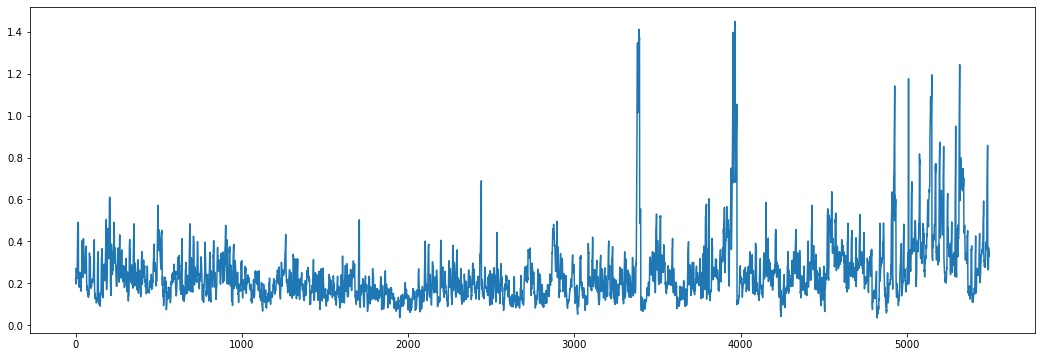

In [106]:
overall_summary['volume_of_ISSR'].plot(figsize=(18,6));

**Decompose Time-Series to see Individual Components (trend + seasonality + noise)**

https://coderzcolumn.com/tutorials/data-science/how-to-remove-trend-and-seasonality-from-time-series-data-using-python-pandas

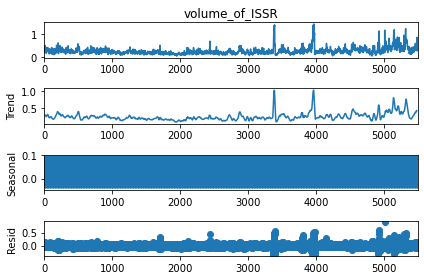

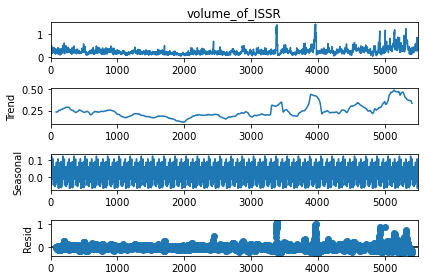

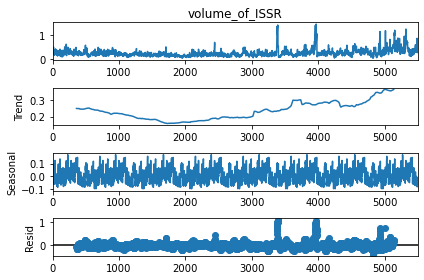

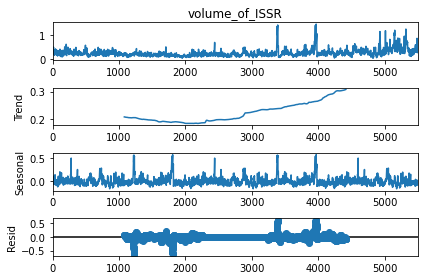

In [107]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result1 = seasonal_decompose(overall_summary['volume_of_ISSR'], period = 24, model="additive")
trend1 = decompose_result1.trend
seasonal1 = decompose_result1.seasonal
residual1 = decompose_result1.resid

decompose_result2 = seasonal_decompose(overall_summary['volume_of_ISSR'], period = 24*7, model="additive")
trend2 = decompose_result2.trend
seasonal2 = decompose_result2.seasonal
residual2 = decompose_result2.resid

decompose_result3 = seasonal_decompose(overall_summary['volume_of_ISSR'], period = 24*30, model="additive")
trend3 = decompose_result3.trend
seasonal3 = decompose_result3.seasonal
residual3 = decompose_result3.resid

decompose_result4 = seasonal_decompose(overall_summary['volume_of_ISSR'], period = 24*90, model="additive")
trend4 = decompose_result4.trend
seasonal4 = decompose_result4.seasonal
residual4 = decompose_result4.resid

decompose_result1.plot()
decompose_result2.plot()
decompose_result3.plot()
decompose_result4.plot();

**Dicky-Fuller Test for Stationarity**

- `p-value > 0.05`: This implies that time-series is non-stationary.
- `p-value <=0.05`: This implies that time-series is stationary.



In [108]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(overall_summary['volume_of_ISSR'], autolag = "AIC" )

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -9.771271556898704
2. P-Value :  7.125549121936177e-17
3. Num Of Lags :  25
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 5470
5. Critical Values :
	 1% :  -3.4315460459585627
	 5% :  -2.8620685329759445
	 10% :  -2.56705133702529


**Conclusion:** 

- The Dicky-Fuller Test shows that **our data is stationary** and there is no necessary to remove trend and seasonality.
- But when we decompose the time-Series by the period of season, **there is a clear trend.**
- The reason why **there is a conflict between Dicky-Fuller Test and visualization** is that **the dataset is too small to generate the long term seasonality and trend**. To deeply analyze the trend and seasonality, we have to collect at least two-year data.
- Therefore, **our data tends to be non-stationary time series** and we need to remove trend and seasonality. But it is imposible to retrieve correct trend and seasonality in such datsaet.
- So, we will use this solution from Coursera Course:
> To predict on non-stationary time series, **we could just train for limited period of time.** For example, here where I take just the last 100 steps. You'll probably get a better performance than if you had trained on the entire time series. But that's breaking the mold for typical machine, learning where we always assume that more data is better. But for time series forecasting it really depends on the time series. If it's stationary, meaning its behavior does not change over time, then great. The more data you have the better. But if it's not stationary then the optimal time window that you should use for training will vary.

# 2. Demo for LR Model

- split the data to training set and validate set with a proportion of around 50% (to limit the period of time)
- define some variables

In [109]:
split_time = 3000  # 1000, 2000, 3000, 4000 as a tuning parameter
time_train = time[:split_time]
x_train = volume_series[:split_time]
time_valid = time[split_time:]
x_valid = volume_series[split_time:]

window_size = 10
batch_size = 100
shuffle_buffer_size = 3000
model_index = 1

- Define functions for the creation of rolling windows and visualizations for final results.
- The output of rolling window function include both predictors and response variable

In [4]:
def windowed_dataset(series, model_index, window_size, batch_size, shuffle_buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + model_index, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + model_index)) # Convert each window to numpy format
    dataset = dataset.shuffle(shuffle_buffer_size, seed = 123).map(lambda window: (window[:-model_index], window[-1])) # Shuffle data and Retrieve features and response variable
    dataset = dataset.batch(batch_size).prefetch(1) # Combines consecutive elements of this dataset into batches
    return dataset
def plot_series(time, series, title, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    plt.grid(True)

- Generate rolling windows
- Train the model

In [111]:
dataset = windowed_dataset(series = x_train, model_index = model_index, 
                           window_size = window_size, 
                           batch_size = batch_size, 
                           shuffle_buffer_size = shuffle_buffer_size)
print(dataset)
L0 = tf.keras.layers.Dense(units = 1, input_shape=[window_size], activation = "relu") # units: Positive integer, dimensionality of the output space.
model = tf.keras.models.Sequential([L0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(L0.get_weights()))


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
Layer weights [array([[-0.45931435],
       [-0.549481  ],
       [ 0.5088469 ],
       [ 0.65520555],
       [ 0.521184  ],
       [-0.43114185],
       [-0.28989932],
       [ 0.3834293 ],
       [-0.04726232],
       [ 0.5424422 ]], dtype=float32), array([0.0018928], dtype=float32)]


- Make prediction for the entire timeline (from timestamp 1 to timestamp 5496): **forecast**
- Retrieve the predicted value for test set: **results_valid**
- Retrieve the predicted value for train set: **results_train**

In [112]:
forecast = []

for time in range(len(volume_series) - window_size):
    forecast.append(model.predict(volume_series[time:time + window_size][np.newaxis]))

# predicted value on validate set
forecast_valid = forecast[split_time-window_size:]
results_valid = np.array(forecast_valid)[:, 0, 0]

# predicted value on training set
forecast_train = forecast[:split_time-window_size]
results_train = np.array(forecast_train)[:, 0, 0]

- Visualization

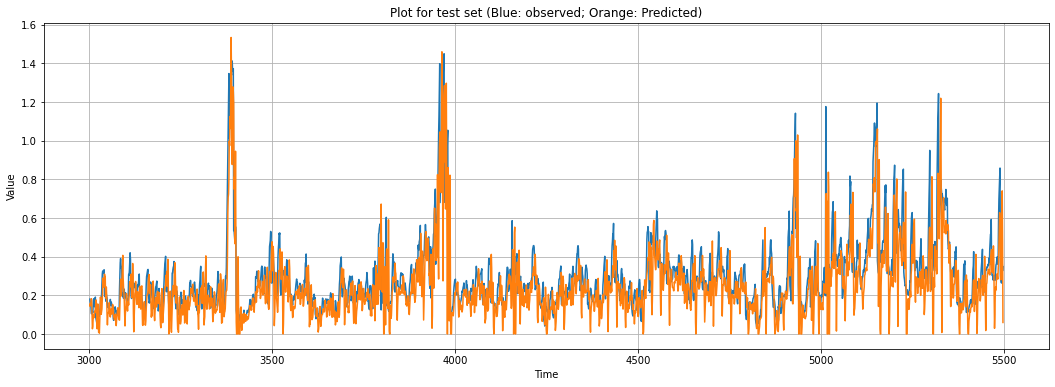

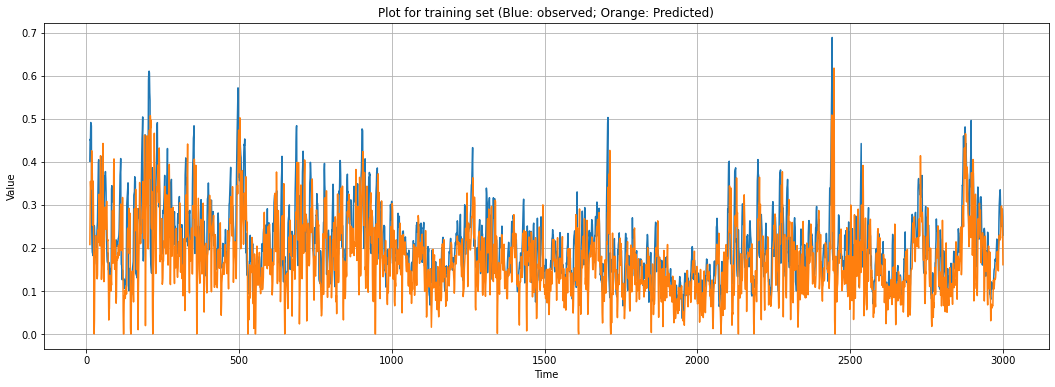

In [113]:
plt.figure(figsize=(18, 6))
plot_series(time_valid, x_valid, title = "Plot for test set (Blue: observed; Orange: Predicted)")
plot_series(time_valid, results_valid, title = "Plot for test set (Blue: observed; Orange: Predicted)");
# Blue: x_valid (observed); Orange: results_valid(predicted)

plt.figure(figsize=(18, 6))
plot_series(time_train[window_size:], x_train[window_size:], title = "Plot for training set (Blue: observed; Orange: Predicted)")
plot_series(time_train[window_size:], results_train, title = "Plot for training set (Blue: observed; Orange: Predicted)");

- Performance

In [114]:
print("MAE(test set) =", tf.keras.metrics.mean_absolute_error(x_valid, results_valid).numpy())
print("MSE(test set) =", tf.keras.metrics.mean_squared_error(x_valid, results_valid).numpy())
print("MAE(training set) =", tf.keras.metrics.mean_absolute_error(x_train[window_size:], results_train).numpy())
print("MSE(training set) =", tf.keras.metrics.mean_squared_error(x_train[window_size:], results_train).numpy())

MAE(test set) = 0.097580925
MSE(test set) = 0.019006576
MAE(training set) = 0.065789394
MSE(training set) = 0.007188299


# The code following is just a test.

In [ ]:
overall_summary = pd.read_csv('overall_summary.csv')
time = overall_summary['datetime_id']
time = time.to_numpy()
volume_series = overall_summary['volume_of_ISSR']
volume_series = volume_series.to_numpy()


split_time = 4000
time_train = time[:split_time]
x_train = volume_series[:split_time]
time_valid = time[split_time:]
x_valid = volume_series[split_time:]

window_size = 10
batch_size = 150
shuffle_buffer_size = 4000
model_index = 1

dataset = windowed_dataset(series = x_train, model_index = model_index, 
                           window_size = window_size, 
                           batch_size = batch_size, 
                           shuffle_buffer_size = shuffle_buffer_size)
print(dataset)
L0 = tf.keras.layers.Dense(units = 1, input_shape=[window_size], activation = "relu") # units: Positive integer, dimensionality of the output space.
model = tf.keras.models.Sequential([L0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(L0.get_weights()))

forecast = []

for time in range(len(volume_series) - window_size):
    forecast.append(model.predict(volume_series[time:time + window_size][np.newaxis]))

# predicted value on validate set
forecast_valid = forecast[split_time-window_size:]
results_valid = np.array(forecast_valid)[:, 0, 0]

# predicted value on training set
forecast_train = forecast[:split_time-window_size]
results_train = np.array(forecast_train)[:, 0, 0]


plt.figure(figsize=(18, 6))
plot_series(time_valid, x_valid, title = "Plot for test set (Blue: observed; Orange: Predicted)")
plot_series(time_valid, results_valid, title = "Plot for test set (Blue: observed; Orange: Predicted)");
# Blue: x_valid (observed); Orange: results_valid(predicted)

plt.figure(figsize=(18, 6))
plot_series(time_train[window_size:], x_train[window_size:], title = "Plot for training set (Blue: observed; Orange: Predicted)")
plot_series(time_train[window_size:], results_train, title = "Plot for training set (Blue: observed; Orange: Predicted)");


print("MAE(test set) =", tf.keras.metrics.mean_absolute_error(x_valid, results_valid).numpy())
print("MSE(test set) =", tf.keras.metrics.mean_squared_error(x_valid, results_valid).numpy())
print("MAE(training set) =", tf.keras.metrics.mean_absolute_error(x_train[window_size:], results_train).numpy())
print("MSE(training set) =", tf.keras.metrics.mean_squared_error(x_train[window_size:], results_train).numpy())

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
